In [1]:
import sqlite3
import pandas as pd
import requests
import asinfo
import matplotlib.dates as dates

from datetime import datetime as dt
import filterbyip as fbi
import clusterbycolumn as cbc

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

### The failures mostly happen due to stall (607) or when the test completes too fast (608)

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , video_id
                  , successes
                  , failures
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
        --   and error_code <> 607       -- stall happened
        --   and error_code <> 608       -- test completed too fast
           order by dtime DESC
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.head()

,probe,dtime,video_address,video_id,successes,failures
0,samsbox08,2017-06-27 23:37:44,2001:b30:ef00:99ca::c,qzlGB3eOjlU,1,0
1,samsbox08,2017-06-27 23:36:40,195.95.178.204,qzlGB3eOjlU,1,0
2,samsbox45,2017-06-27 23:36:12,None,qzlGB3eOjlU,0,1
3,samsbox03,2017-06-27 23:36:00,2001:1a80:801::c,qzlGB3eOjlU,1,0
4,samsbox45,2017-06-27 23:35:09,173.194.20.202,qzlGB3eOjlU,1,0


In [9]:
num_probes = len(set(df['probe']))

In [10]:
def round_time_to_day(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(hour=0, minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_day)

In [12]:
df.head()

,probe,dtime,video_address,video_id,successes,failures
0,samsbox08,2017-06-27,2001:b30:ef00:99ca::c,qzlGB3eOjlU,1,0
1,samsbox08,2017-06-27,195.95.178.204,qzlGB3eOjlU,1,0
2,samsbox45,2017-06-27,None,qzlGB3eOjlU,0,1
3,samsbox03,2017-06-27,2001:1a80:801::c,qzlGB3eOjlU,1,0
4,samsbox45,2017-06-27,173.194.20.202,qzlGB3eOjlU,1,0


In [13]:
df.tail()

,probe,dtime,video_address,video_id,successes,failures
5241629,samsbox24,2014-08-20,173.194.137.147,u5KQQWlIgGc,1,0
5241630,samsbox24,2014-08-20,None,u5KQQWlIgGc,0,1
5241631,samsbox24,2014-08-20,None,u5KQQWlIgGc,0,1
5241632,samsbox24,2014-08-20,173.194.137.147,u5KQQWlIgGc,1,0
5241633,samsbox24,2014-08-20,None,u5KQQWlIgGc,0,1


In [14]:
df.count()

probe            5241634
dtime            5241634
video_address    4727767
video_id         5241633
successes        5241634
failures         5241634
dtype: int64

In [15]:
def get_af_from_endpoint(ep):
    if ep is None: return None
    elif fbi.if_ipv6(ep): return 'v6'
    elif fbi.if_ipv4(ep): return 'v4'
    else: print('.'); return None

In [16]:
df['af'] = df['video_address'].apply(get_af_from_endpoint)

.


In [17]:
df.count()

probe            5241634
dtime            5241634
video_address    4727767
video_id         5241633
successes        5241634
failures         5241634
af               4727766
dtype: int64

In [18]:
df.head()

,probe,dtime,video_address,video_id,successes,failures,af
0,samsbox08,2017-06-27,2001:b30:ef00:99ca::c,qzlGB3eOjlU,1,0,v6
1,samsbox08,2017-06-27,195.95.178.204,qzlGB3eOjlU,1,0,v4
2,samsbox45,2017-06-27,None,qzlGB3eOjlU,0,1,None
3,samsbox03,2017-06-27,2001:1a80:801::c,qzlGB3eOjlU,1,0,v6
4,samsbox45,2017-06-27,173.194.20.202,qzlGB3eOjlU,1,0,v4


In [19]:
df.head()

,probe,dtime,video_address,video_id,successes,failures,af
0,samsbox08,2017-06-27,2001:b30:ef00:99ca::c,qzlGB3eOjlU,1,0,v6
1,samsbox08,2017-06-27,195.95.178.204,qzlGB3eOjlU,1,0,v4
2,samsbox45,2017-06-27,None,qzlGB3eOjlU,0,1,None
3,samsbox03,2017-06-27,2001:1a80:801::c,qzlGB3eOjlU,1,0,v6
4,samsbox45,2017-06-27,173.194.20.202,qzlGB3eOjlU,1,0,v4


In [21]:
dfgroupby = cbc.group(df, column=['dtime', 'af', 'probe'])

In [22]:
df_agg = cbc.aggregate(dfgroupby, ['successes', 'failures'], ['sum', 'count'])

In [23]:
df_merged = cbc.merge(df, df_agg, column=['dtime', 'af', 'probe'])

In [24]:
df = df_merged.drop(['video_address', 'video_id', 'successes', 'failures'], axis=1)

In [25]:
df = df.drop_duplicates()

In [26]:
df.count()

probe                 117995
dtime                 117995
af                    117995
(successes, sum)      117995
(successes, count)    117995
(failures, sum)       117995
(failures, count)     117995
dtype: int64

In [27]:
df.rename( columns={  df.columns[-1]: 'failures_count'
                    , df.columns[-2]: 'failures_sum'
                    , df.columns[-3]: 'successes_count'
                    , df.columns[-4]: 'successes_sum'}
                , inplace=True)

In [28]:
df.head()

,probe,dtime,af,successes_sum,successes_count,failures_sum,failures_count
0,samsbox08,2017-06-27,v6,24,24,0,24
1,samsbox08,2017-06-27,v4,24,24,0,24
3,samsbox03,2017-06-27,v6,24,24,0,24
4,samsbox45,2017-06-27,v4,24,24,0,24
5,samsbox03,2017-06-27,v4,24,24,0,24


In [29]:
dfv6 = df[df.af == 'v6']
dfv4 = df[df.af == 'v4']

In [30]:
dfv6.head()

,probe,dtime,af,successes_sum,successes_count,failures_sum,failures_count
0,samsbox08,2017-06-27,v6,24,24,0,24
3,samsbox03,2017-06-27,v6,24,24,0,24
6,samsbox97,2017-06-27,v6,18,18,0,18
8,samsbox51,2017-06-27,v6,24,24,0,24
9,samsbox33,2017-06-27,v6,24,24,0,24


In [31]:
def cal_success_rate(x):
    success = x['successes_sum']
    total   = x['successes_count']    
    
    rate = (success / total) * 100
    return rate

dfv6['success_rate'] = dfv6.apply(cal_success_rate, axis = 1)
dfv4['success_rate'] = dfv4.apply(cal_success_rate, axis = 1)

In [32]:
del dfv4['successes_sum']; del dfv4['successes_count']
del dfv6['successes_sum']; del dfv6['successes_count']

del dfv4['failures_sum']; del dfv4['failures_count']
del dfv6['failures_sum']; del dfv6['failures_count']

In [33]:
del dfv4['af']; del dfv6['af']

In [34]:
dfv4.head()

,probe,dtime,success_rate
1,samsbox08,2017-06-27,100.0
4,samsbox45,2017-06-27,100.0
5,samsbox03,2017-06-27,100.0
7,samsbox97,2017-06-27,100.0
12,samsbox51,2017-06-27,100.0


In [35]:
dfv6.head()

,probe,dtime,success_rate
0,samsbox08,2017-06-27,100.0
3,samsbox03,2017-06-27,100.0
6,samsbox97,2017-06-27,100.0
8,samsbox51,2017-06-27,100.0
9,samsbox33,2017-06-27,100.0


In [36]:
def get_success_rate_across_probes(df):
    dfgroupby  = cbc.group(df, column=['dtime'])
    df_agg     = cbc.aggregate(dfgroupby, ['success_rate'], ['median'])
    df_merged  = cbc.merge(df, df_agg, column=['dtime'])
    df         = df_merged.drop(['probe', 'success_rate'], axis=1)
    df         = df.drop_duplicates()
    df.columns = ['dtime', 'success_rate']
    return df

dfv4 = get_success_rate_across_probes(dfv4)
dfv6 = get_success_rate_across_probes(dfv6)

In [37]:
dfv6.head()

,dtime,success_rate
0,2017-06-27,100.0
3427,2017-06-26,100.0
10241,2017-06-25,100.0
20543,2017-06-24,100.0
34667,2017-06-23,100.0


In [39]:
dfv4['dtime'] = dfv4['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d'))
dfv6['dtime'] = dfv6['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d'))

TypeError: strptime() argument 1 must be str, not Timestamp

In [41]:
dfv4.sort_values(by = 'dtime', inplace = True)
dfv6.sort_values(by = 'dtime', inplace = True)

In [42]:
num_4 = dfv4['dtime'].count()

In [43]:
num_6 = dfv6['dtime'].count()

### Hardcoded dates

In [45]:
from dateutil import rrule
a=dt.strptime(str('2014-08-01'), '%Y-%m-%d')
b=dt.strptime(str('2017-07-01'), '%Y-%m-%d')
dateranges = rrule.rrule(rrule.DAILY, dtstart=a).between(a, b, inc=True)

In [48]:
df_ = pd.DataFrame(dateranges, columns=['dtime']).sort_values(by = 'dtime').reset_index(drop = True)

In [49]:
dfv4 = pd.merge(df_, dfv4, how='outer')
dfv6 = pd.merge(df_, dfv6, how='outer')

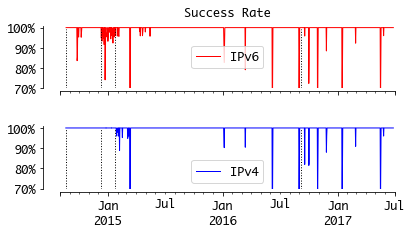

In [55]:
fig = plt.figure(figsize=(6, 3))
plt.rcParams['font.size'] = 12

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

sl = dfv6.plot(  x='dtime'
               , y=['success_rate']
               , color='red'
               , kind='line'
               , linewidth = 1
               , ax = ax1
              )

st = dfv4.plot(  x='dtime'
               , y=['success_rate']
               , color='blue'
               , kind='line'
               , linewidth = 1
               , ax = ax2
              )

ax1.grid(False)
ax1.legend(['IPv6'], fontsize=12, loc='best')
ax1.set_yscale('linear')
ax1.set_ylim([70, 101])

ax2.grid(False)
ax2.legend(['IPv4'], fontsize=12, loc='best')
ax2.set_yscale('linear')
ax2.set_ylim([70, 101])

yticks = np.arange(70,110,10)
ax1.set_yticks(yticks)
ax2.set_yticks(yticks)

def to_percent(y, position): return str(int(y)) + '%'
ax1.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax2.yaxis.set_major_formatter(FuncFormatter(to_percent))

from datetime import datetime as dt
ax1.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

ax1.set_xlabel('', fontsize=22)
ax1.set_ylabel('', fontsize=22)
ax2.set_xlabel('', fontsize=22)
ax2.set_ylabel('', fontsize=22)

fig.subplots_adjust(hspace = 0.6)

ax1.set_title('Success Rate', fontsize=12, y=1.05)
plt.savefig('youtube-success-rate-timeseries.pdf', format='pdf', bbox_inches='tight')

In [56]:
dfv4 = dfv4.dropna()
dfv6 = dfv6.dropna()

In [57]:
import Cdf
import Pmf
samplev4 = dfv4['success_rate'].values
samplev6 = dfv6['success_rate'].values

c4 = Cdf.MakeCdfFromList(samplev4)
c6 = Cdf.MakeCdfFromList(samplev6)

cc4 = [1 - p for x, p in c4.Items()]
cc6 = [1 - p for x, p in c6.Items()]